In [1]:
from functools import reduce
import scipy
from copy import deepcopy
from scipy.linalg import logm
import numpy as np
import dill


In [2]:
import dill 
num_keep = 750
filename = '../pickled_controls5.pkl'
pca = dill.load(open(filename, 'rb'))
pca.controlset = pca.controlset[:num_keep]

In [3]:
def hist_and_support(weights, num=10):
    plt.hist(weights)
    np.argmax(weights)
    top_idx = np.argsort(np.array(weights).T)[0][-num:]
    top_values = [weights[i] for i in top_idx]
    print(f"SUPPORT:{np.sum(top_values)}")
    print(f"NUM CONTROLS: {num}")
    return top_idx

# Plotting Utils

In [4]:
%matplotlib inline 
def oned_off_diagonals(pca, scale):
    import itertools
    from itertools import product
    import multiprocessing
    from pauli_channel_approximation import compute_dpn_and_fid
    import matplotlib.pyplot as plt
    %matplotlib inline 


    def generate_indices(num_points, order_desired):
        num_indices = len(order_desired)
        tuples = product(range(num_points), repeat=num_indices)
        indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
        return indices

    values_to_plot = []
    corr = []
    for i, detuning in enumerate(pca.detunings):
        # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
        values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
        values_to_plot.append(values)
        corr.append(i)
    # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
    combinations = list(zip(values, [0 for _ in values]))
    # Multiprocessing for faster evaluation.
    pool = multiprocessing.Pool(num_processors)
    lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs)
           for combo in combinations]
    projs_fidelities = pool.map(compute_dpn_and_fid, lst)
    pool.close()
    # Compute the off diagonals and fidelities.
    projs = [pf[0] for pf in projs_fidelities]
    fidelities = [pf[1] for pf in projs_fidelities]
    projs = np.vstack(projs).T
    fidelities = np.vstack(fidelities).T
    plt.figure(figsize=(16, 8))  # the first figure
    plt.subplot(211)  # the first subplot in the first figure
    
    for i, row in enumerate(projs[:-1, :]):
        plt.plot(range(len(row)), row)
    plt.plot(range(len(projs[-1, :])), projs[-1, :], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()
    plt.axvline((num_points-1)/2)
    plt.subplot(212)  # the second subplot in the first figure
    
    for i, row in enumerate(fidelities[:-1, :]):
        plt.plot(range(len(row)), -np.log(1 - row))
    plt.plot(range(len(fidelities[-1, :])), -np.log(1 - fidelities[-1, :]), label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("f")
    samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
    labels = -(np.exp(-samples) - 1)
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.yticks(samples, labels)
    plt.tight_layout()
    plt.show()

def off_diagonals(pca, scale):
    import itertools
    from itertools import product
    import multiprocessing
    from pauli_channel_approximation import compute_dpn_and_fid
    import matplotlib.pyplot as plt

    def generate_indices(num_points, order_desired):
        num_indices = len(order_desired)
        tuples = product(range(num_points), repeat=num_indices)
        indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
        return indices

    values_to_plot = []
    corr = []
    for i, detuning in enumerate(pca.detunings):
        # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
        values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
        values_to_plot.append(values)
        corr.append(i)
    # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
    combinations = itertools.product(*values_to_plot)
    new_combinations = []
    for combo in combinations:
        new_combo = []
        for index in corr:
            new_combo.append(combo[index])
        new_combinations.append(new_combo)
    combinations = new_combinations

    tuple_length = len(combinations[0])
    standard_ordering = list(range(tuple_length))
    ordering = standard_ordering
    indices = generate_indices(len(values), ordering)

    # Multiprocessing for faster evaluation.
    pool = multiprocessing.Pool(num_processors)
    lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
            pca.control_hamiltonians, pca.target_operator, pca.probs)
           for combo in combinations]
    projs_fidelities = pool.map(compute_dpn_and_fid, lst)
    
    print(projs_fidelities)
    pool.close()

    # Compute the off diagonals and fidelities.
    projs = [pf[0] for pf in projs_fidelities]
    fidelities = [pf[1] for pf in projs_fidelities]
    projs = np.vstack(projs).T
    fidelities = np.vstack(fidelities).T
    plt.figure(figsize=(16, 8))  # the first figure
    plt.subplot(211)  # the first subplot in the first figure

    for i, row in enumerate(projs[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(range(len(row)), reordered_row)
    plt.plot(range(len(projs[-1, :])), [projs[-1, :][i] for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()
    plt.subplot(212)  # the second subplot in the first figure
    for i, row in enumerate(fidelities[:-1, :]):
        reordered_row = np.array([row[j] for j in indices])
        plt.plot(range(len(row)), -np.log(1 - reordered_row))
    plt.plot(range(len(fidelities[-1, :])), [-np.log(1 - fidelities[-1, :][i]) for i in indices], label="min", color='k', linewidth=2, zorder=10)
    plt.legend()
    plt.ylabel("f")
    samples = np.linspace(plt.ylim()[0], plt.ylim()[1], 11)
    labels = -(np.exp(-samples) - 1)
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.yticks(samples, labels)
    plt.tight_layout()
    plt.show()
    
def off_diagonals2(pca1, pca2, scale):
    for l, pca in enumerate([pca1, pca2]):
        import itertools
        from itertools import product
        import multiprocessing
        from pauli_channel_approximation import compute_dpn_and_fid
        import matplotlib.pyplot as plt
        
        def generate_indices(num_points, order_desired):
            num_indices = len(order_desired)
            tuples = product(range(num_points), repeat=num_indices)
            indices = [sum([num_points**(num_indices - 1 - order_desired[i]) * t[i] for i in range(num_indices)]) for t in tuples]
            return indices

        values_to_plot = []
        corr = []
        for i, detuning in enumerate(pca.detunings):
            # This sets the x axis (It's okay to pick detuning[0] because they were all set to the same detuning.)
            values = np.linspace(-detuning[0]/scale, detuning[0]/scale, num_points)
            values_to_plot.append(values)
            corr.append(i)
        # This was when I was evaluating more detuning combinations before, now this is just indexing over each detuning param.
        combinations = itertools.product(*values_to_plot)
        new_combinations = []
        for combo in combinations:
            new_combo = []
            for index in corr:
                new_combo.append(combo[index])
            new_combinations.append(new_combo)
        combinations = new_combinations

        tuple_length = len(combinations[0])
        standard_ordering = list(range(tuple_length))
        ordering = standard_ordering
        indices = generate_indices(len(values), ordering)

        # Multiprocessing for faster evaluation.
        pool = multiprocessing.Pool(num_processors)
        lst = [(pca.controlset, pca.ambient_hamiltonian, combo, pca.dt,
                pca.control_hamiltonians, pca.target_operator, pca.probs)
               for combo in combinations]
        projs_fidelities = pool.map(compute_dpn_and_fid, lst)
        pool.close()

        # Compute the off diagonals and fidelities.
        projs = [pf[0] for pf in projs_fidelities]
        fidelities = [pf[1] for pf in projs_fidelities]
        projs = np.vstack(projs).T
        fidelities = np.vstack(fidelities).T
        # If you just uncomment the first two rows it fails for some reason...
#         for i, row in enumerate(projs[:-1, :]):
#             reordered_row = np.array([row[j] for j in indices])
#             plt.plot(range(len(row)), reordered_row)
        plt.plot(range(len(projs[-1, :])), [projs[-1, :][i] for i in indices], c=['r','b'][l], linewidth=2, zorder=10, label=['1st order', '0th order'][l])
    plt.legend()
    plt.ylabel("Absolute Sum of Off Diagonal Elements")
    plt.semilogy()


In [5]:
num_weights = 8
scale = 100
num_points = 21
num_processors = 4

In [9]:
from ..convex import all_derivs, optimal_weights_1st_order, optimal_weights
from pauli_channel_approximation import PCA
# If the tolerance is too high (i.e. not zero) and the number of controls is too high (e.g. >100) this was failing with ECOS.
PCA.assign_weights(pca, 0, 1E-3)

ValueError: attempted relative import beyond top-level package

SUPPORT:1.0000003198590357
NUM CONTROLS: 8


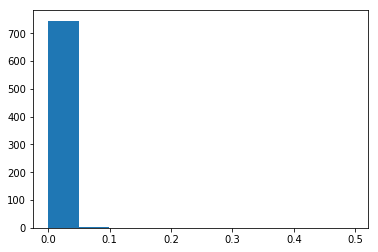

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
indices = hist_and_support(pca.weights, num_weights)

In [9]:
indices

array([679, 644, 354,  61, 669, 203, 301, 112])

DOING COMBO [-1e-05, -1e-05]
DOING COMBO [-9e-06, -3e-06]
DOING COMBO [-6e-06, -1e-05]
DOING COMBO [-8.000000000000001e-06, 4.000000000000001e-06]
DOING COMBO [-1e-05, -9e-06]
DOING COMBO [-9e-06, -1.9999999999999995e-06]
DOING COMBO [-6e-06, -9e-06]
DOING COMBO [-8.000000000000001e-06, 5.000000000000001e-06]
DOING COMBO [-1e-05, -8.000000000000001e-06]
DOING COMBO [-9e-06, -9.99999999999999e-07]
DOING COMBO [-6e-06, -8.000000000000001e-06]
DOING COMBO [-1e-05, -7.000000000000001e-06]
DOING COMBO [-8.000000000000001e-06, 6.000000000000002e-06]
DOING COMBO [-9e-06, 1.6940658945086007e-21]
DOING COMBO [-6e-06, -7.000000000000001e-06]
DOING COMBO [-1e-05, -6e-06]
DOING COMBO [-8.000000000000001e-06, 7.0000000000000024e-06]
DOING COMBO [-9e-06, 1.0000000000000006e-06]
DOING COMBO [-6e-06, -6e-06]
DOING COMBO [-1e-05, -4.9999999999999996e-06]
DOING COMBO [-9e-06, 2.000000000000001e-06]
DOING COMBO [-1e-05, -4e-06]
DOING COMBO [-8.000000000000001e-06, 8.000000000000003e-06]
DOING COMBO [-6e-

DOING COMBO [-1.9999999999999995e-06, 4.000000000000001e-06]
DOING COMBO [-9.99999999999999e-07, 9.000000000000004e-06]
DOING COMBO [-4e-06, -1e-05]
DOING COMBO [-3e-06, -9.99999999999999e-07]
DOING COMBO [-1.9999999999999995e-06, 5.000000000000001e-06]
DOING COMBO [-9.99999999999999e-07, 1e-05]
DOING COMBO [-4e-06, -9e-06]
DOING COMBO [-3e-06, 1.6940658945086007e-21]
DOING COMBO [-1.9999999999999995e-06, 6.000000000000002e-06]
DOING COMBO [1.6940658945086007e-21, -1e-05]
DOING COMBO [-4e-06, -8.000000000000001e-06]
DOING COMBO [-3e-06, 1.0000000000000006e-06]
DOING COMBO [-1.9999999999999995e-06, 7.0000000000000024e-06]
DOING COMBO [1.6940658945086007e-21, -9e-06]
DOING COMBO [-4e-06, -7.000000000000001e-06]
DOING COMBO [-3e-06, 2.000000000000001e-06]
DOING COMBO [-1.9999999999999995e-06, 8.000000000000003e-06]
DOING COMBO [1.6940658945086007e-21, -8.000000000000001e-06]
DOING COMBO [-4e-06, -6e-06]
DOING COMBO [-3e-06, 3.0000000000000018e-06]
DOING COMBO [-1.9999999999999995e-06, 9.0

DOING COMBO [4.000000000000001e-06, 1.6940658945086007e-21]
DOING COMBO [5.000000000000001e-06, 5.000000000000001e-06]
DOING COMBO [1.0000000000000006e-06, 1e-05]
DOING COMBO [3.0000000000000018e-06, -4.9999999999999996e-06]
DOING COMBO [4.000000000000001e-06, 1.0000000000000006e-06]
DOING COMBO [6.000000000000002e-06, -1e-05]
DOING COMBO [5.000000000000001e-06, 6.000000000000002e-06]
DOING COMBO [3.0000000000000018e-06, -4e-06]
DOING COMBO [4.000000000000001e-06, 2.000000000000001e-06]
DOING COMBO [6.000000000000002e-06, -9e-06]
DOING COMBO [5.000000000000001e-06, 7.0000000000000024e-06]
DOING COMBO [7.0000000000000024e-06, -3e-06]
DOING COMBO [4.000000000000001e-06, 3.0000000000000018e-06]
DOING COMBO [5.000000000000001e-06, 8.000000000000003e-06]
DOING COMBO [6.000000000000002e-06, -8.000000000000001e-06]
DOING COMBO [8.000000000000003e-06, 4.000000000000001e-06]
DOING COMBO [7.0000000000000024e-06, -1.9999999999999995e-06]
DOING COMBO [5.000000000000001e-06, 9.000000000000004e-06]


/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


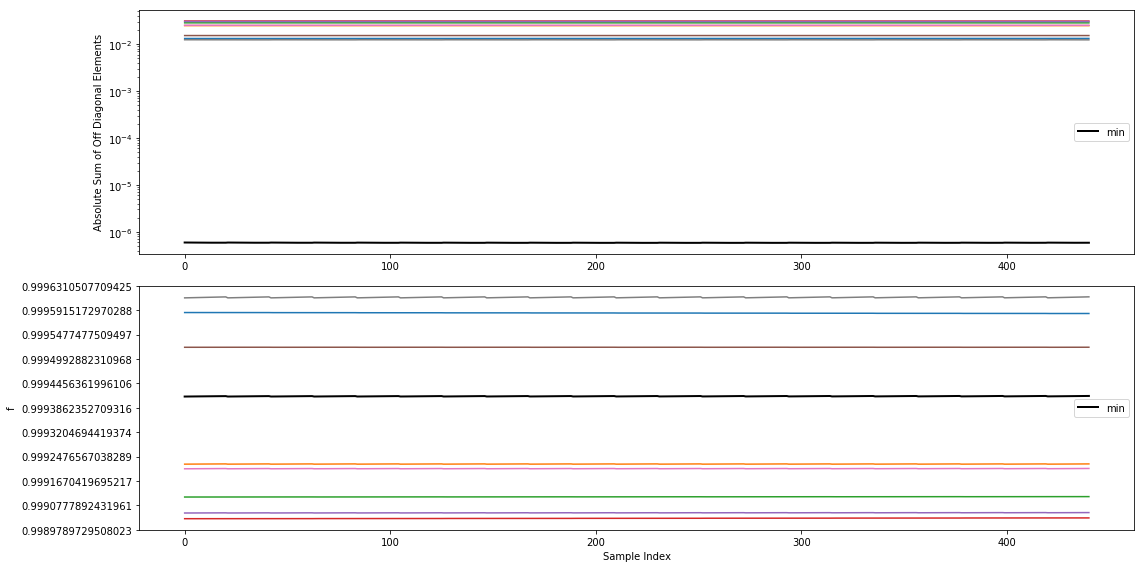

In [10]:

#pca1 = dill.load(open('../../../repos/randomized_controls/' + pcas[choice], 'rb'))
pca1 = dill.load(open(filename, 'rb'))
subweights = pca.weights[indices]
pca1.controlset = [pca1.controlset[i] for i in indices]
pca1.probs = list(np.array(subweights.T/sum(subweights)).T)
off_diagonals(pca1, scale)


SUPPORT:0.9999992169526183
NUM CONTROLS: 8


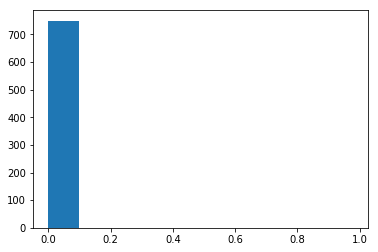

In [11]:
import matplotlib.pyplot as plt
num_weights0 = num_weights
%matplotlib inline
indices = hist_and_support(pca.weights_0, num_weights0)

SUPPORT:0.9999992169526183
NUM CONTROLS: 8
DOING COMBO [-1e-05, -1e-05]
DOING COMBO [-9e-06, -3e-06]
DOING COMBO [-8.000000000000001e-06, 4.000000000000001e-06]
DOING COMBO [-6e-06, -1e-05]
DOING COMBO [-9e-06, -1.9999999999999995e-06]
DOING COMBO [-1e-05, -9e-06]
DOING COMBO [-8.000000000000001e-06, 5.000000000000001e-06]
DOING COMBO [-6e-06, -9e-06]
DOING COMBO [-6e-06, -8.000000000000001e-06]
DOING COMBO [-9e-06, -9.99999999999999e-07]
DOING COMBO [-8.000000000000001e-06, 6.000000000000002e-06]
DOING COMBO [-1e-05, -8.000000000000001e-06]
DOING COMBO [-9e-06, 1.6940658945086007e-21]
DOING COMBO [-9e-06, 1.0000000000000006e-06]
DOING COMBO [-6e-06, -7.000000000000001e-06]
DOING COMBO [-8.000000000000001e-06, 7.0000000000000024e-06]
DOING COMBO [-1e-05, -7.000000000000001e-06]
DOING COMBO [-9e-06, 2.000000000000001e-06]
DOING COMBO [-8.000000000000001e-06, 8.000000000000003e-06]
DOING COMBO [-1e-05, -6e-06]
DOING COMBO [-9e-06, 3.0000000000000018e-06]
DOING COMBO [-6e-06, -6e-06]
DOIN

DOING COMBO [-4e-06, -8.000000000000001e-06]
DOING COMBO [-3e-06, -3e-06]
DOING COMBO [-9.99999999999999e-07, 8.000000000000003e-06]
DOING COMBO [-1.9999999999999995e-06, 5.000000000000001e-06]
DOING COMBO [-4e-06, -7.000000000000001e-06]
DOING COMBO [-3e-06, -1.9999999999999995e-06]
DOING COMBO [-1.9999999999999995e-06, 6.000000000000002e-06]
DOING COMBO [-9.99999999999999e-07, 9.000000000000004e-06]
DOING COMBO [-4e-06, -6e-06]
DOING COMBO [-1.9999999999999995e-06, 7.0000000000000024e-06]
DOING COMBO [-9.99999999999999e-07, 1e-05]
DOING COMBO [-3e-06, -9.99999999999999e-07]
DOING COMBO [-4e-06, -4.9999999999999996e-06]
DOING COMBO [-3e-06, 1.6940658945086007e-21]
DOING COMBO [-1.9999999999999995e-06, 8.000000000000003e-06]
DOING COMBO [1.6940658945086007e-21, -1e-05]
DOING COMBO [-3e-06, 1.0000000000000006e-06]
DOING COMBO [-4e-06, -4e-06]
DOING COMBO [-3e-06, 2.000000000000001e-06]
DOING COMBO [-4e-06, -3e-06]
DOING COMBO [-1.9999999999999995e-06, 9.000000000000004e-06]
DOING COMBO 

DOING COMBO [4.000000000000001e-06, 1.6940658945086007e-21]
DOING COMBO [3.0000000000000018e-06, -4.9999999999999996e-06]
DOING COMBO [6.000000000000002e-06, -9e-06]
DOING COMBO [4.000000000000001e-06, 1.0000000000000006e-06]
DOING COMBO [3.0000000000000018e-06, -4e-06]
DOING COMBO [5.000000000000001e-06, 3.0000000000000018e-06]
DOING COMBO [6.000000000000002e-06, -8.000000000000001e-06]
DOING COMBO [4.000000000000001e-06, 2.000000000000001e-06]
DOING COMBO [5.000000000000001e-06, 4.000000000000001e-06]
DOING COMBO [7.0000000000000024e-06, -3e-06]
DOING COMBO [6.000000000000002e-06, -7.000000000000001e-06]
DOING COMBO [4.000000000000001e-06, 3.0000000000000018e-06]
DOING COMBO [7.0000000000000024e-06, -1.9999999999999995e-06]
DOING COMBO [5.000000000000001e-06, 5.000000000000001e-06]
DOING COMBO [6.000000000000002e-06, -6e-06]
DOING COMBO [7.0000000000000024e-06, -9.99999999999999e-07]
DOING COMBO [8.000000000000003e-06, 4.000000000000001e-06]
DOING COMBO [5.000000000000001e-06, 6.0000

/home/anthony/.pyenv/versions/3.6.3/envs/personal/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


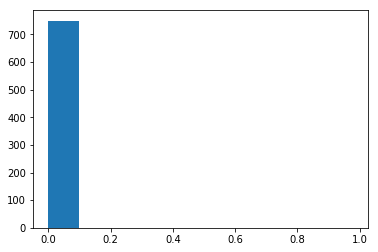

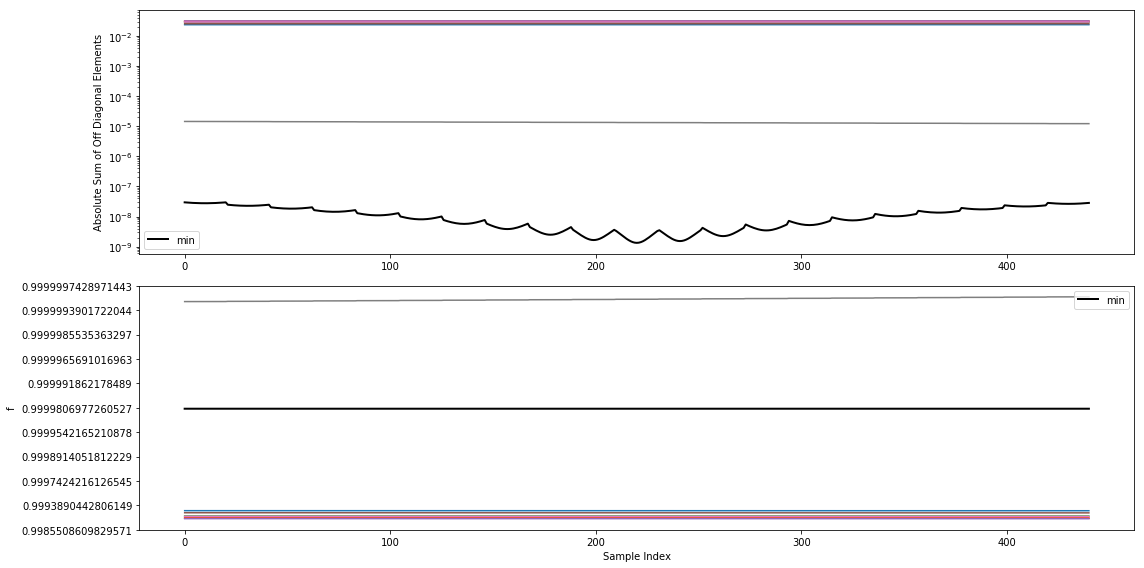

In [12]:
import matplotlib.pyplot as plt

#pca0 = dill.load(open('../../../repos/randomized_controls/' + pcas[choice], 'rb'))
pca0 = dill.load(open(filename, 'rb'))
indices = hist_and_support(pca.weights_0, num_weights0)
subweights = pca.weights_0[indices]
pca0.controlset = [pca0.controlset[i] for i in indices]
pca0.probs = list(np.array(subweights.T/sum(subweights)).T)
off_diagonals(pca0, scale)


In [13]:
# off_diagonals2(pca1, pca0, scale/2)

# 750

DOING COMBO [-7.2e-05, -2.4e-05]
DOING COMBO [-6.400000000000001e-05, 3.2000000000000005e-05]
DOING COMBO [-8e-05, -8e-05]
DOING COMBO [-4.8e-05, -8e-05]
DOING COMBO [-8e-05, -7.2e-05]
DOING COMBO [-6.400000000000001e-05, 4.000000000000001e-05]
DOING COMBO [-8e-05, -6.400000000000001e-05]
DOING COMBO [-4.8e-05, -7.2e-05]
DOING COMBO [-7.2e-05, -1.5999999999999996e-05]
DOING COMBO [-8e-05, -5.6000000000000006e-05]
DOING COMBO [-6.400000000000001e-05, 4.8000000000000015e-05]
DOING COMBO [-8e-05, -4.8e-05]
DOING COMBO [-4.8e-05, -6.400000000000001e-05]
DOING COMBO [-7.2e-05, -7.999999999999991e-06]
DOING COMBO [-6.400000000000001e-05, 5.600000000000002e-05]
DOING COMBO [-8e-05, -3.9999999999999996e-05]
DOING COMBO [-4.8e-05, -5.6000000000000006e-05]
DOING COMBO [-7.2e-05, 1.3552527156068805e-20]
DOING COMBO [-6.400000000000001e-05, 6.400000000000002e-05]
DOING COMBO [-8e-05, -3.2e-05]
DOING COMBO [-4.8e-05, -4.8e-05]
DOING COMBO [-7.2e-05, 8.000000000000005e-06]
DOING COMBO [-6.4000000000

DOING COMBO [-7.999999999999991e-06, 5.600000000000002e-05]
DOING COMBO [-2.4e-05, -2.4e-05]
DOING COMBO [-3.2e-05, -5.6000000000000006e-05]
DOING COMBO [-7.999999999999991e-06, 6.400000000000002e-05]
DOING COMBO [-1.5999999999999996e-05, 1.600000000000001e-05]
DOING COMBO [-2.4e-05, -1.5999999999999996e-05]
DOING COMBO [-3.2e-05, -4.8e-05]
DOING COMBO [-7.999999999999991e-06, 7.200000000000003e-05]
DOING COMBO [-1.5999999999999996e-05, 2.4000000000000014e-05]
DOING COMBO [-2.4e-05, -7.999999999999991e-06]
DOING COMBO [-3.2e-05, -3.9999999999999996e-05]
DOING COMBO [-7.999999999999991e-06, 8e-05]
DOING COMBO [-1.5999999999999996e-05, 3.2000000000000005e-05]
DOING COMBO [-2.4e-05, 1.3552527156068805e-20]
DOING COMBO [-3.2e-05, -3.2e-05]
DOING COMBO [1.3552527156068805e-20, -8e-05]
DOING COMBO [-1.5999999999999996e-05, 4.000000000000001e-05]
DOING COMBO [-2.4e-05, 8.000000000000005e-06]
DOING COMBO [-3.2e-05, -2.4e-05]
DOING COMBO [1.3552527156068805e-20, -7.2e-05]
DOING COMBO [-1.599999

DOING COMBO [4.8000000000000015e-05, -8e-05]
DOING COMBO [4.000000000000001e-05, 2.4000000000000014e-05]
DOING COMBO [2.4000000000000014e-05, -5.6000000000000006e-05]
DOING COMBO [3.2000000000000005e-05, -2.4e-05]
DOING COMBO [4.8000000000000015e-05, -7.2e-05]
DOING COMBO [2.4000000000000014e-05, -4.8e-05]
DOING COMBO [4.000000000000001e-05, 3.2000000000000005e-05]
DOING COMBO [4.8000000000000015e-05, -6.400000000000001e-05]
DOING COMBO [3.2000000000000005e-05, -1.5999999999999996e-05]
DOING COMBO [4.8000000000000015e-05, -5.6000000000000006e-05]
DOING COMBO [4.000000000000001e-05, 4.000000000000001e-05]
DOING COMBO [4.8000000000000015e-05, -4.8e-05]
DOING COMBO [2.4000000000000014e-05, -3.9999999999999996e-05]
DOING COMBO [3.2000000000000005e-05, -7.999999999999991e-06]
DOING COMBO [4.8000000000000015e-05, -3.9999999999999996e-05]
DOING COMBO [4.8000000000000015e-05, -3.2e-05]
DOING COMBO [4.000000000000001e-05, 4.8000000000000015e-05]
DOING COMBO [3.2000000000000005e-05, 1.3552527156

DOING COMBO [-8e-05, -7.999999999999991e-06]
DOING COMBO [-5.6000000000000006e-05, -6.400000000000001e-05]
DOING COMBO [-7.2e-05, 4.8000000000000015e-05]
DOING COMBO [-8e-05, 1.3552527156068805e-20]
DOING COMBO [-4.8e-05, -7.999999999999991e-06]
DOING COMBO [-5.6000000000000006e-05, -5.6000000000000006e-05]
DOING COMBO [-7.2e-05, 5.600000000000002e-05]
DOING COMBO [-8e-05, 8.000000000000005e-06]
DOING COMBO [-4.8e-05, 1.3552527156068805e-20]
DOING COMBO [-5.6000000000000006e-05, -4.8e-05]
DOING COMBO [-8e-05, 1.600000000000001e-05]
DOING COMBO [-7.2e-05, 6.400000000000002e-05]
DOING COMBO [-4.8e-05, 8.000000000000005e-06]
DOING COMBO [-5.6000000000000006e-05, -3.9999999999999996e-05]
DOING COMBO [-8e-05, 2.4000000000000014e-05]
DOING COMBO [-7.2e-05, 7.200000000000003e-05]
DOING COMBO [-4.8e-05, 1.600000000000001e-05]
DOING COMBO [-5.6000000000000006e-05, -3.2e-05]
DOING COMBO [-8e-05, 3.2000000000000005e-05]
DOING COMBO [-7.2e-05, 8e-05]
DOING COMBO [-4.8e-05, 2.4000000000000014e-05]


DOING COMBO [1.3552527156068805e-20, -3.9999999999999996e-05]
DOING COMBO [-7.999999999999991e-06, -8e-05]
DOING COMBO [-2.4e-05, 4.000000000000001e-05]
DOING COMBO [-3.2e-05, -1.5999999999999996e-05]
DOING COMBO [1.3552527156068805e-20, -3.2e-05]
DOING COMBO [-2.4e-05, 4.8000000000000015e-05]
DOING COMBO [-7.999999999999991e-06, -7.2e-05]
DOING COMBO [-3.2e-05, -7.999999999999991e-06]
DOING COMBO [1.3552527156068805e-20, -2.4e-05]
DOING COMBO [-2.4e-05, 5.600000000000002e-05]
DOING COMBO [-7.999999999999991e-06, -6.400000000000001e-05]
DOING COMBO [-3.2e-05, 1.3552527156068805e-20]
DOING COMBO [1.3552527156068805e-20, -1.5999999999999996e-05]
DOING COMBO [-7.999999999999991e-06, -5.6000000000000006e-05]
DOING COMBO [-2.4e-05, 6.400000000000002e-05]
DOING COMBO [-3.2e-05, 8.000000000000005e-06]
DOING COMBO [-2.4e-05, 7.200000000000003e-05]
DOING COMBO [-7.999999999999991e-06, -4.8e-05]
DOING COMBO [1.3552527156068805e-20, -7.999999999999991e-06]
DOING COMBO [-3.2e-05, 1.600000000000001

DOING COMBO [4.8000000000000015e-05, -3.9999999999999996e-05]
DOING COMBO [5.600000000000002e-05, 1.3552527156068805e-20]
DOING COMBO [4.000000000000001e-05, 8e-05]
DOING COMBO [4.8000000000000015e-05, -3.2e-05]
DOING COMBO [6.400000000000002e-05, 4.8000000000000015e-05]
DOING COMBO [5.600000000000002e-05, 8.000000000000005e-06]
DOING COMBO [8e-05, -8e-05]
DOING COMBO [4.8000000000000015e-05, -2.4e-05]
DOING COMBO [6.400000000000002e-05, 5.600000000000002e-05]
DOING COMBO [8e-05, -7.2e-05]
DOING COMBO [5.600000000000002e-05, 1.600000000000001e-05]
DOING COMBO [4.8000000000000015e-05, -1.5999999999999996e-05]
DOING COMBO [6.400000000000002e-05, 6.400000000000002e-05]
DOING COMBO [5.600000000000002e-05, 2.4000000000000014e-05]
DOING COMBO [8e-05, -6.400000000000001e-05]
DOING COMBO [4.8000000000000015e-05, -7.999999999999991e-06]
DOING COMBO [6.400000000000002e-05, 7.200000000000003e-05]
DOING COMBO [8e-05, -5.6000000000000006e-05]
DOING COMBO [5.600000000000002e-05, 3.2000000000000005e-

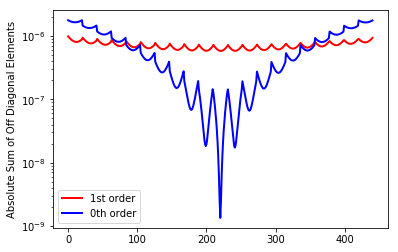

In [14]:
off_diagonals2(pca1, pca0, scale/8)